Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['fear_greed_index.csv', 'historical_data.csv', 'cleaned_trader_data.gsheet', 'cleaned_sentiment_data.csv', 'cleaned_trader_data.csv']


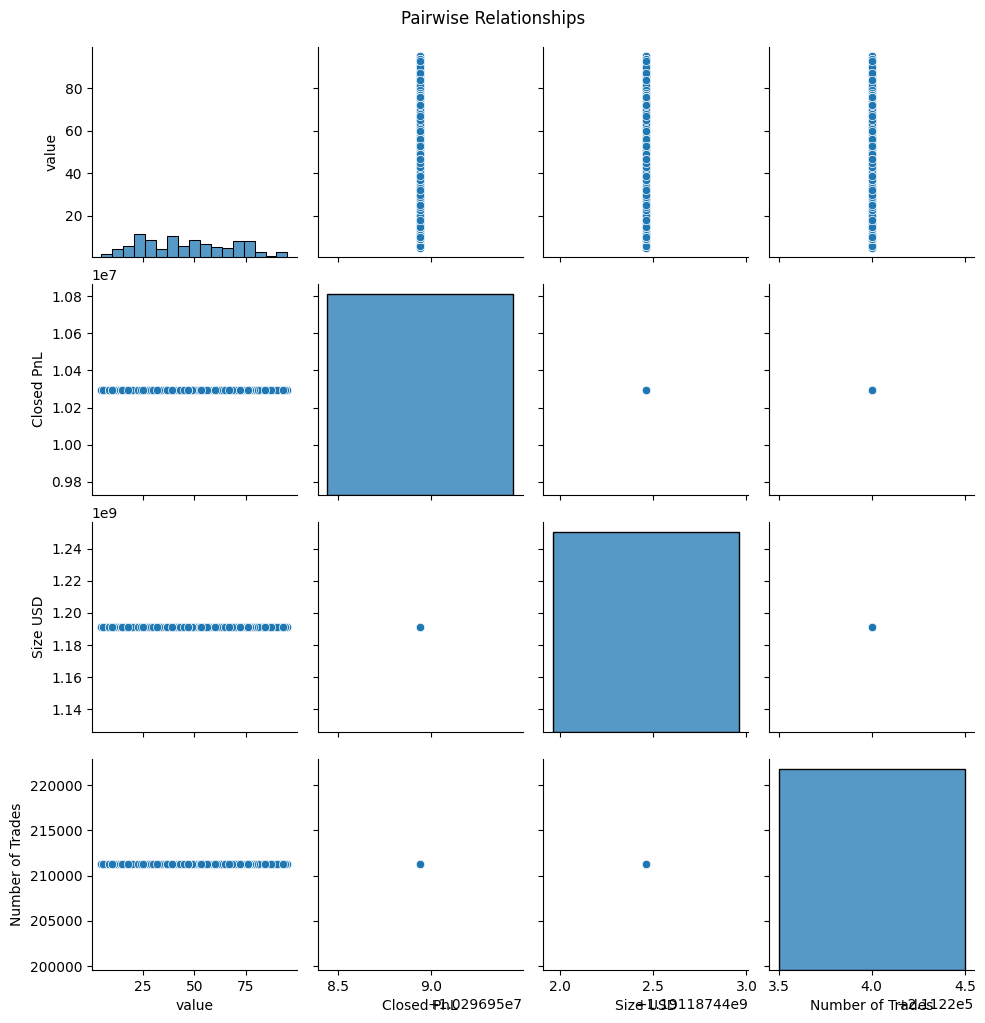

In [1]:
# Mount Google Drive to access project files
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

## Mount the Google Drive so that you can access files stored there
drive.mount('/content/drive')

## List the contents of the working directory to confirm files are in place
print(os.listdir('/content/drive/MyDrive/ds_mahek/csv_files'))

# Define the paths to your raw input files
trader_path = '/content/drive/MyDrive/ds_mahek/csv_files/historical_data.csv'
sentiment_path = '/content/drive/MyDrive/ds_mahek/csv_files/fear_greed_index.csv'

# Load both CSVs into pandas DataFrames
trader_df = pd.read_csv(trader_path)
sentiment_df = pd.read_csv(sentiment_path)

##Preview the first few rows of each dataset to verify they loaded correctly
#trader_df.head()
#sentiment_df.head()

# --------------------------------------------
# DATA CLEANING & PREPARATION
# --------------------------------------------

# Convert the 'Timestamp' column to datetime format (essential for time-series analysis)
trader_df['Timestamp'] = pd.to_datetime(trader_df['Timestamp'])

# Convert relevant financial columns to numeric format (in case they were read as strings)
# 'errors="coerce"' replaces invalid parsing with NaN
trader_df['Size USD'] = pd.to_numeric(trader_df['Size USD'], errors='coerce')
trader_df['Closed PnL'] = pd.to_numeric(trader_df['Closed PnL'], errors='coerce')

# Drop rows with missing values in critical columns: 'Timestamp', 'Size USD', 'Closed PnL'
trader_df = trader_df.dropna(subset=['Timestamp', 'Size USD', 'Closed PnL'])

# Convert 'timestamp' in sentiment data to datetime
sentiment_df['timestamp'] = pd.to_datetime(sentiment_df['timestamp'])

# Ensure the 'value' column (Fear & Greed Index) is numeric
sentiment_df['value'] = pd.to_numeric(sentiment_df['value'], errors='coerce')

# Drop rows with missing timestamps or sentiment values
sentiment_df = sentiment_df.dropna(subset=['timestamp', 'value'])

# --------------------------------------------
# FEATURE ENGINEERING & JOINING
# --------------------------------------------

# Extract date (yyyy-mm-dd) from the datetime columns for daily aggregation
trader_df['date'] = trader_df['Timestamp'].dt.date
sentiment_df['date'] = sentiment_df['timestamp'].dt.date

# Aggregate trader data by date
# This creates daily metrics: total PnL, total trade size, and trade count
daily_trader_df = trader_df.groupby('date').agg({
    'Closed PnL': 'sum',              # Total profit or loss per day
    'Size USD': 'sum',                # Total trading volume per day
    'Trade ID': 'count'               # Number of trades per day
}).rename(columns={'Trade ID': 'Number of Trades'}).reset_index()

# Merge the aggregated trader data with sentiment data on the 'date' column
merged_df = pd.merge(
    daily_trader_df,
    sentiment_df[['date', 'value', 'classification']],
    on='date',
    how='inner'                      # Only keep dates that exist in both datasets
)

# --------------------------------------------
# SAVE CLEANED DATA FOR FUTURE USE
# --------------------------------------------

##Save cleaned trader dataset
#cleaned_trader_path = '/content/drive/MyDrive/ds_mahek/csv_files/cleaned_trader_data.csv'
#trader_df.to_csv(cleaned_trader_path, index=False)

# Save cleaned sentiment dataset
#cleaned_sentiment_path = '/content/drive/MyDrive/ds_mahek/csv_files/cleaned_sentiment_data.csv'
#sentiment_df.to_csv(cleaned_sentiment_path, index=False)

# --------------------------------------------
# VISUALIZATION
# --------------------------------------------

# Define path to save the pairplot visualization
plot_path = '/content/drive/MyDrive/ds_mahek/outputs/correlation_plot.png'

# Create a pairplot to show relationships between:
# Sentiment value, PnL, USD Size, and Number of Trades
sns.pairplot(merged_df[['value', 'Closed PnL', 'Size USD', 'Number of Trades']])
plt.suptitle('Pairwise Relationships', y=1.02)

# Save the plot to your outputs folder
plt.savefig(plot_path)

# Display the plot in notebook
plt.show()

